<h2 id="anexob" style="background-color: #80B8D1 ; color: white; padding: 5px;font-size: 20px;">ANEXO B - IMPUTACIÓN RUL</h2>

### CARGA DE LIBRERÍAS Y DATOS

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os
from scipy.stats import chi2_contingency
from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import GroupShuffleSplit, RandomizedSearchCV, GroupKFold,cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

In [2]:
path = "../CMaps/"
train_doc = "train_FD004.txt"
test_doc = "test_FD004.txt"
test_target_doc="RUL_FD004.txt"

indices = ["unit_num", "cycle"]
settings = ["setting_1", "setting_2", "setting_3"]
sensor = ["s_{}".format(i+1) for i in range(0,21)]
col_nombres = indices + settings + sensor

# Leer los datos
train = pd.read_csv((path+train_doc), sep="\s+", header=None, 
                 names=col_nombres)
test = pd.read_csv((path+test_doc), sep="\s+", header=None, 
                 names=col_nombres)
y_test = pd.read_csv((path+test_target_doc), sep="\s+", header=None, 
                 names=["RUL"])

### CÁLCULO DE LA VÍDA ÚTIL REMANENTE (RUL)

Dado que no se dispone de información directa sobre la RUL en el conjunto de datos de entrenamiento, sino sobre la cantidad de ciclos que un motor realiza antes de su fallo, se deben crear estimaciones.

En los análisis de predicción de vida útil remanente existen diferentes enfoques para modelar la degradación de un equipo. El enfoque menos complejo es el de *degradación lineal*, donde se asume que la vida útil disminuye de manera constante en cada ciclo hasta alcanzar un valor de cero en el momento de la falla. Sin embargo, existe otro enfoque conocido como *degradación lineal por tramos (clipped)* en el que se asume que la vida útil de la unidad se mantiene constante durante la mayoría de los ciclos y luego de un determinado punto disminuye linealmente hasta alcanzar cero. Lo anterior se basa en el hecho de que la degradación de un sistema generalmente no es perceptible hasta después de que la unidad haya sido utilizada durante algún período de tiempo y haya ocurrido una falla inicial. Si un motor es nuevo y se encuentra trabajado en condiciones saludables, es poco razonable que se comience a dar una degradación. Solo después de que la unidad haya sido utilizada durante un tiempo, la degradación se hará evidente. Por lo antedicho, parece razonable estimar la RUL mediante un modelo de degradación lineal por tramos.

En los datos de entrenamiento, el último ciclo reportado para cada motor corresponde al ciclo en el que ocurre la falla, por lo tanto, en ese punto, la vida útil remanente es cero. En el ciclo anterior, sabemos que le queda un ciclo, en el ciclo previo a ese, le quedan dos, y así sucesivamente hasta llegar al valor "clip" a partir del cual no se considera que haya degradación. La imputación de los valores de RUL se llevó a cabo de acuerdo con esta lógica.

La siguiente función permite calcular los valores de la RUL según el esquema mencionado tanto si se considera una degradación lineal o por tramos. En caso de trabajar con una degradación por tramos se debe incluir el valor "clip" dentro de la variable denominada *early*. 

In [3]:
def RUL_add(dataframe,clipped=False,early=None):
    if "unit_num" in dataframe.columns and "cycle" in dataframe.columns:

        df_rul=dataframe.groupby("unit_num")["cycle"].max().reset_index()
        df_rul.columns=["unit_num","max"]
        dataframe = pd.merge(dataframe, df_rul, on="unit_num")
        dataframe["RUL"]=dataframe["max"]-dataframe["cycle"]
        dataframe=dataframe.drop(labels="max",axis=1)

        if clipped:
             dataframe["RUL"]=dataframe["RUL"].clip(upper=early)

        return dataframe
    else:
        print("El dataframe debe contener las columnas unit_num y cycle")

### COMPARACIÓN DE MODELOS DE DEGRADACIÓN

El siguiente paso consistió en comparar los resultados obtenidos utilizando ambos modelos de degradación. A su vez, dentro del modelo de degradación por tramos se probarán distintos valores de corte (clip). Previo a esto, para poder determinar un rango adecuado de valores de corte se volvió a analizar la relación que existe entre los diferentes sensores y la variable objetivo. En este punto, se imputó la RUL de forma lineal a efectos de visualizar esas relaciones.  

In [4]:
train["setting_1"]=train["setting_1"].round(decimals=1)
train["setting_2"]=train["setting_2"].round(decimals=2)

In [5]:
X_train=RUL_add(train,False,None)

In [6]:
X_train.head()

,unit_num,cycle,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,1,42.0,0.84,100.0,445.00,549.68,1343.43,1112.93,3.91,...,2387.99,8074.83,9.3335,0.02,330,2212,100.00,10.62,6.3670,320
1,1,2,20.0,0.70,100.0,491.19,606.07,1477.61,1237.50,9.35,...,2387.73,8046.13,9.1913,0.02,361,2324,100.00,24.37,14.6552,319
2,1,3,42.0,0.84,100.0,445.00,548.95,1343.12,1117.05,3.91,...,2387.97,8066.62,9.4007,0.02,329,2212,100.00,10.48,6.4213,318
3,1,4,42.0,0.84,100.0,445.00,548.70,1341.24,1118.03,3.91,...,2388.02,8076.05,9.3369,0.02,328,2212,100.00,10.54,6.4176,317
4,1,5,25.0,0.62,60.0,462.54,536.10,1255.23,1033.59,7.05,...,2028.08,7865.80,10.8366,0.02,305,1915,84.93,14.03,8.6754,316


El siguiente gráfico presenta la relación entre los diferentes sensores y la RUL. Esto se realizó en un conjunto seleccionado de motores con el propósito de facilitar la identificación de patrones o tendencias en la degradación a medida que se acerca la falla del motor.

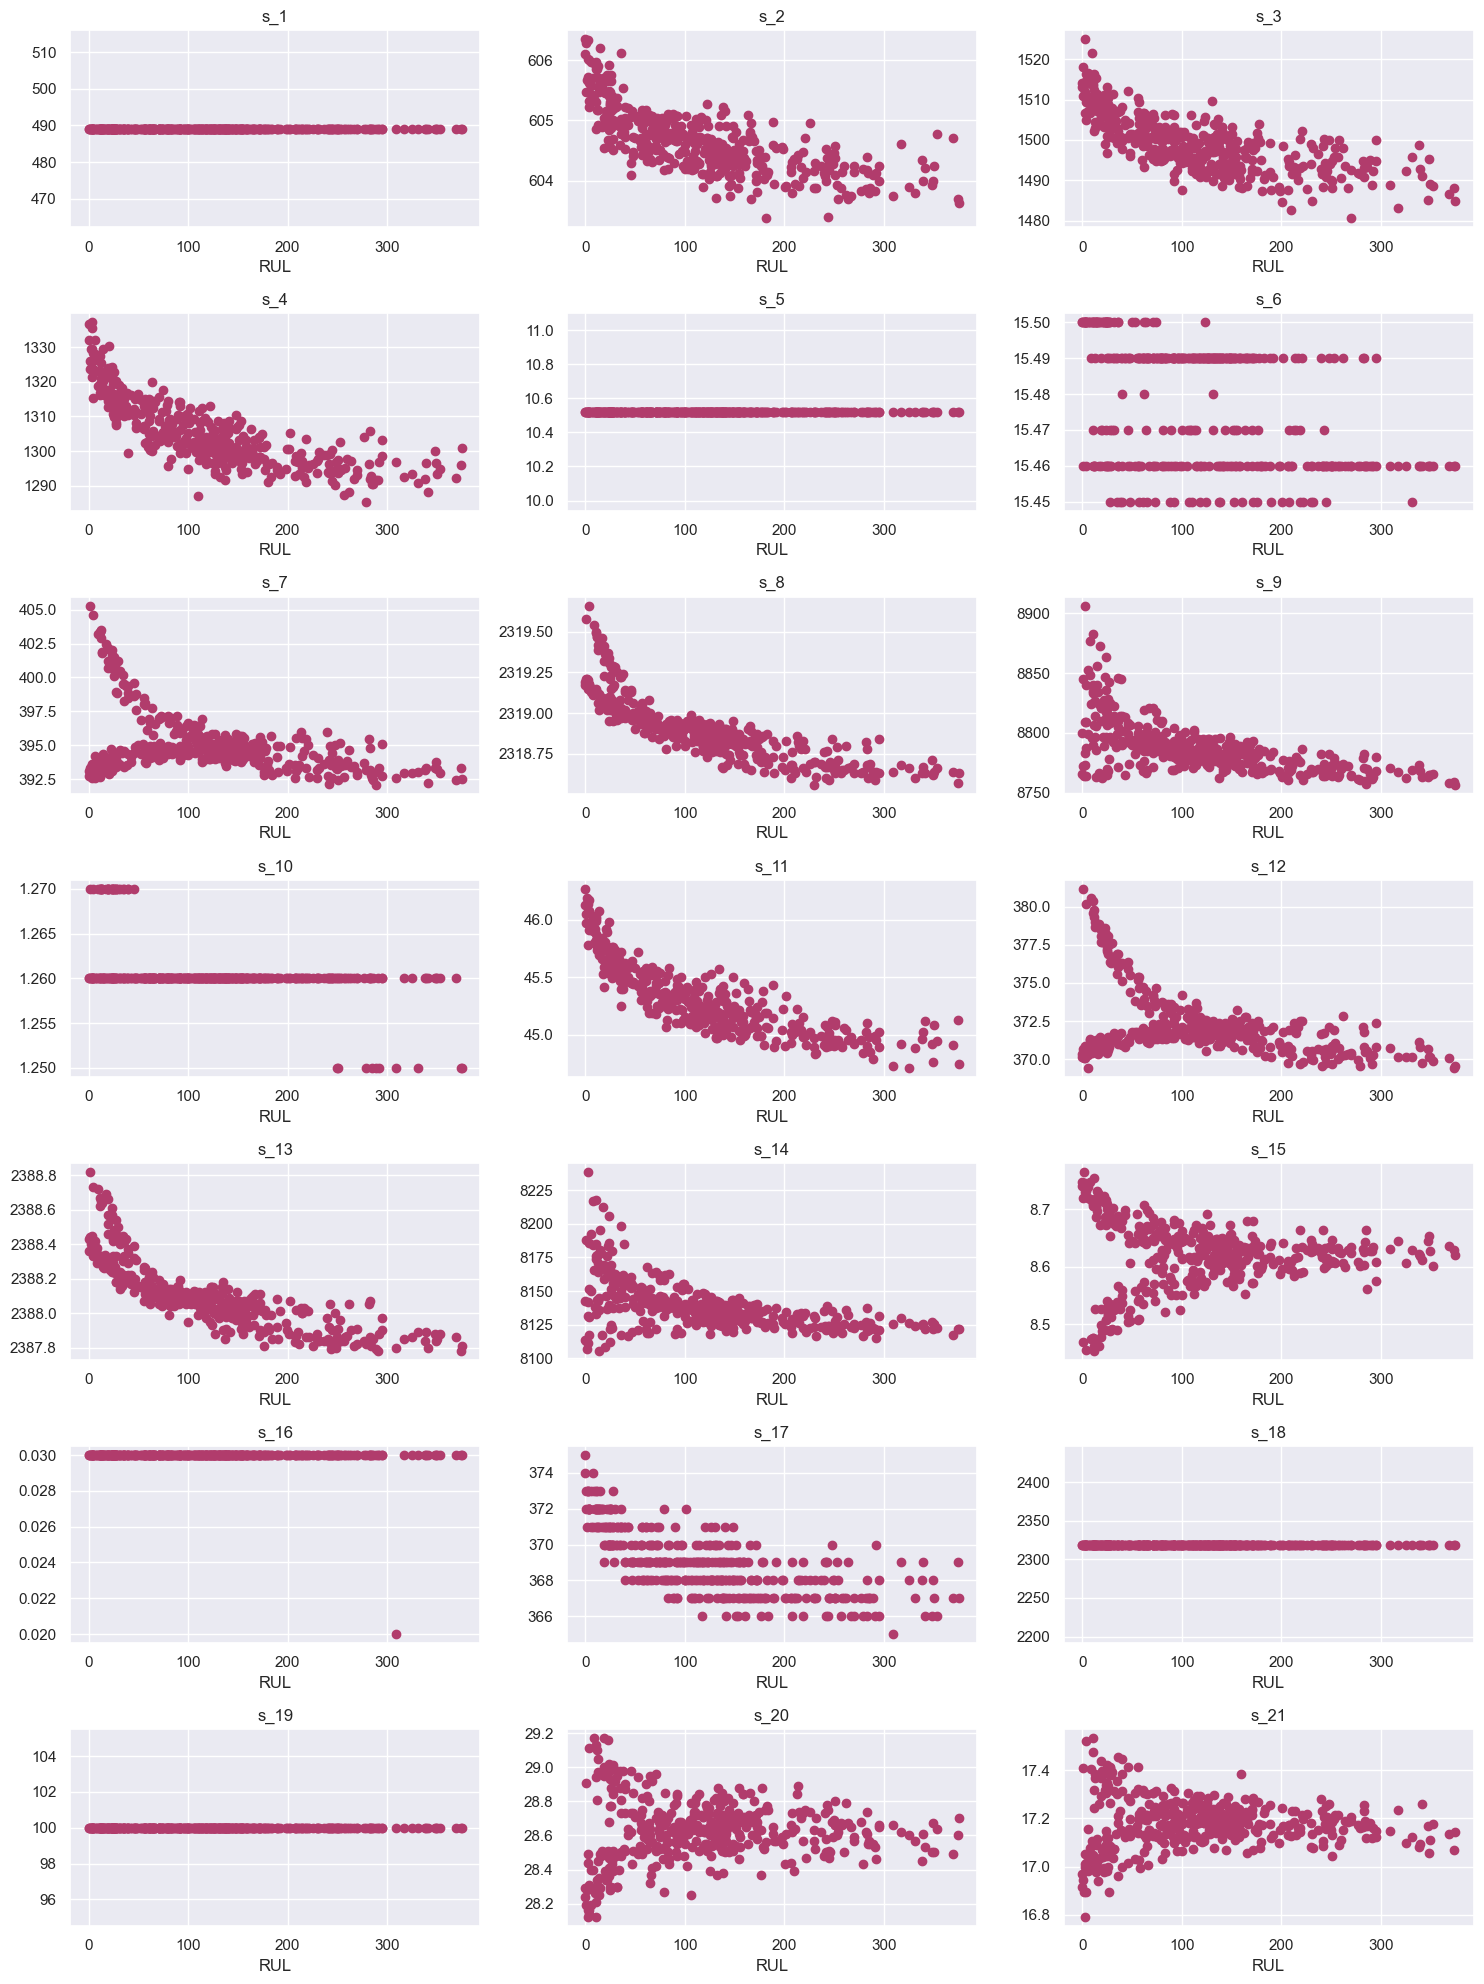

In [7]:
unidades = [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 249]

X_train["condición_op"] = X_train["setting_1"].astype(str) + "_" + \
                          X_train["setting_2"].astype(str) + "_" + \
                          X_train["setting_3"].astype(str)
X_train_filtro = X_train[X_train["unit_num"].isin(unidades)]

X_train_filtro = X_train_filtro.loc[X_train_filtro["condición_op"] ==  X_train_filtro["condición_op"].unique()[0]]

num_sensors = 21 
num_rows = 7
num_columns = 3
palette = sns.color_palette("flare", 6)

fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 20))
sensors = ["s_1", "s_2", "s_3", "s_4", "s_5", "s_6", "s_7", "s_8", "s_9", "s_10",
           "s_11", "s_12", "s_13", "s_14", "s_15", "s_16", "s_17", "s_18", "s_19", "s_20", "s_21"]

for i, sensor in enumerate(sensors):
    row = i // num_columns
    col = i % num_columns
    axs[row, col].scatter(X_train_filtro["RUL"], X_train_filtro[sensor], color=palette[3])
    axs[row, col].set_title(f"{sensor}")
    axs[row, col].set_xlabel("RUL")
    axs[row, col].set_ylabel
    
plt.tight_layout()
plt.show()

Con relación a los sensores que exhiben una correlación aparente con la variable objetivo, se observa lo siguiente:

- En condiciones de alta vida útil remanente, los valores de estos sensores tienden a mantenerse relativamente constantes.
- A medida que la RUL disminuye y el equipo se aproxima a la falla, se evidencian cambios en los valores de estos sensores. Estos cambios pueden manifestarse tanto como incrementos como disminuciones, dependiendo del sensor en cuestión.
- Independientemente de si los valores se incrementan o reducen cuando se inicia la degradación, todos los sensores experimentan algún el cambio cuando la RUL se sitúa en el rango de 100 a 200 unidades. 

Por tanto, parece razonable considerar ese rango como un valor de corte (clip) en el modelo de degradación lineal por tramos. Antes de ese punto, los sensores no reflejan señales de degradación significativa, lo que sugiere que el equipo está funcionando en condiciones relativamente estables. 

A continuación, se realizó la comparación entre los modelos de degradación mediante validación cruzada (20 splits y val_size=15%). 

In [8]:
seed=42
resultados=[]
X_train.drop(labels="condición_op",axis=1)

for i in ["lineal",125,150,175,200]:
    if i =="lineal":
        clipped=False
        early=None
       
    else:
        clipped=True
        early=i
        
    #Train
    X_train=RUL_add(train,clipped,early)
    groups=X_train.unit_num 

    y_train=X_train.RUL
    X_train=X_train.drop(labels=["RUL","cycle","unit_num"],axis=1) 

    #Test
    X_test=test.groupby("unit_num").last().reset_index()
    X_test=X_test.drop(labels=["unit_num","cycle"],axis=1)

    model = LinearRegression()

    #Se evalúa el modelo 
    gss = GroupShuffleSplit(n_splits=20, test_size=0.15, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, groups=groups, cv=gss,scoring="neg_root_mean_squared_error")
    resultados.append(-scores) 

<AxesSubplot: >

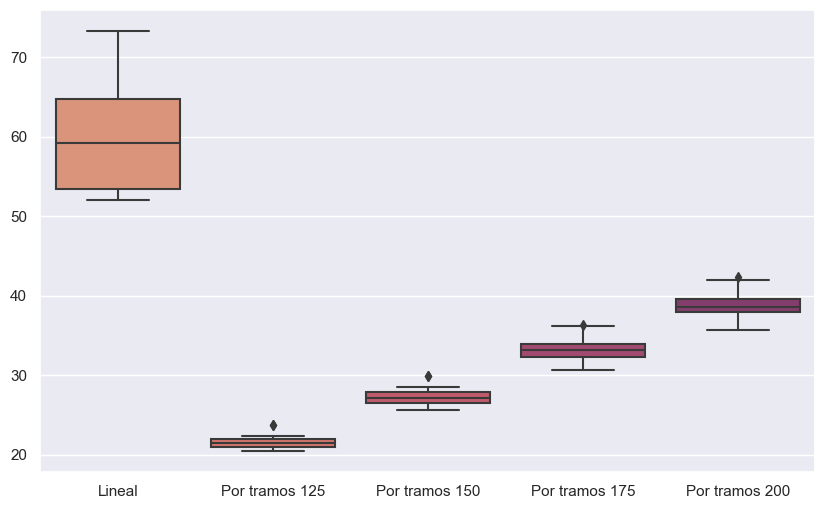

In [9]:
df=pd.DataFrame(resultados).transpose()
df.columns=["Lineal", "Por tramos 125","Por tramos 150","Por tramos 175","Por tramos 200"]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,palette=palette)

Se observa claramente que el modelo de degradación por tramos arroja resultados mucho más prometedores, y en particular con un valor de corte de 125.
Ya que la comparación se realizó con un modelo de regresión lineal, se procede a repetir el proceso utilizando un modelo del tipo Random Forest. Esto se hace con el objetivo de fortalecer aún más la decisión, optando por un modelo que capture relaciones no lineales, como el Random Forest, a modo de ejemplo.

In [10]:
seed=42
resultados=[]

for i in ["lineal",125,150,175,200]:
    if i =="lineal":
        clipped=False
        early=None
       
    else:
        clipped=True
        early=i
        
    #Train
    X_train=RUL_add(train,clipped,early)
    groups=X_train.unit_num 

    y_train=X_train.RUL
    X_train=X_train.drop(labels=["RUL","cycle","unit_num"],axis=1) 

    #Test
    X_test=test.groupby("unit_num").last().reset_index()
    X_test=X_test.drop(labels=["unit_num","cycle"],axis=1)

    model = RandomForestRegressor(random_state=seed,n_jobs=-1)

    #Se evalúa el modelo 
    gss = GroupShuffleSplit(n_splits=20, test_size=0.15, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, groups=groups, cv=gss,scoring="neg_root_mean_squared_error")
    resultados.append(-scores) 

<AxesSubplot: >

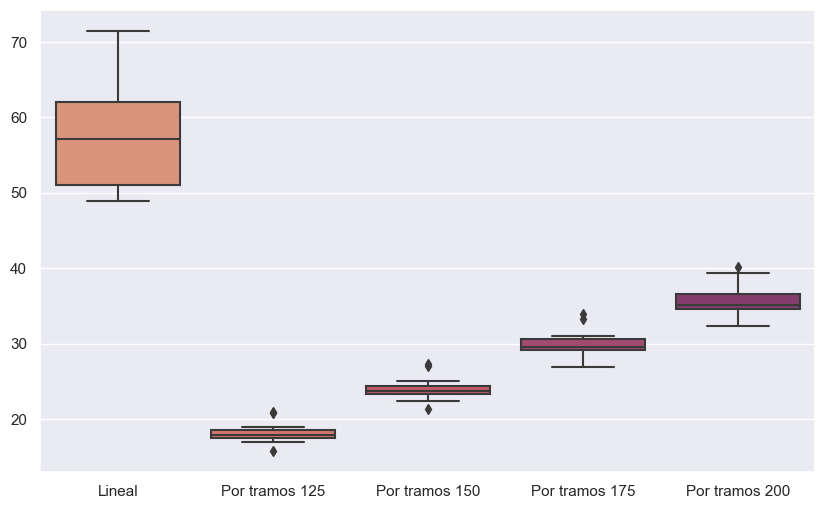

In [11]:
df=pd.DataFrame(resultados).transpose()
df.columns=["Lineal", "Por tramos 125","Por tramos 150","Por tramos 175","Por tramos 200"]
plt.figure(figsize=(10, 6))
sns.boxplot(data=df,palette=palette)

En base a los resultados se reafirma la selección de un modelo de degradación lineal por tramos con un valor de "clip" de 125.

In [1]:
from IPython.core.display import HTML, display

style = """
<style>
div.output_area {
    max-height: 500px; 
}

.rendered_html p {
    text-align: justify;
    font-size: 13px;
}

.rendered_html ul li, .rendered_html ol li {
    font-size: 13px;
}

.rendered_html h2#eda {
    background-color: #80B8D1;
    color: white;
    padding: 10px;
    font-size: 18px;
}
</style>
"""

display(HTML(style))
